# **스파크 colab에 환경 구현**

In [1]:
# jdk 툴 설치
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# apache spark download - 하둡 버전에 따라 spakr 와 하둡 변경 (밑에 tgz 파일 설치 및 pip install)
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# 명령어로 spark - hadoop 파일 압축 풀기
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
# spark 설치
!pip install -q findspark

In [2]:
import os
# spark 환경변수 설정 - java(jdk) ,spark(spark) 2개다 설정해줘야함
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
#import spark 말고 findspark로 spark파일을 못찾는경우에 빠르게 설치 가능
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

# **카탈리스트(Catalyst)와 텅스텐(Tungsten)엔진**

**스파크 백엔드(Spark Backend)**  스파크 백엔드에 관한 것이며, 스파크 백엔드는 이 두 프로젝트로 최적화가 된다.

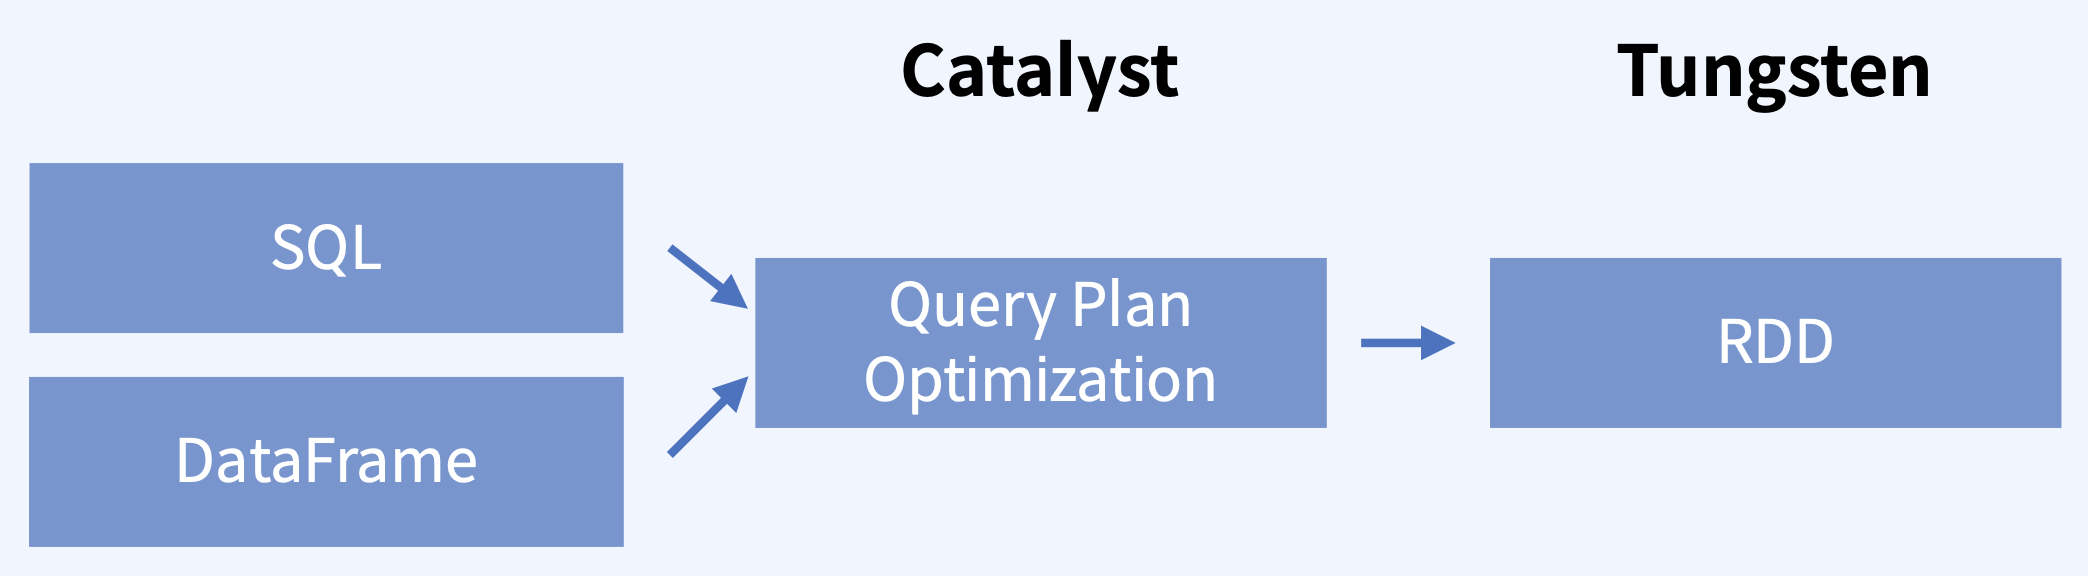

스파크는 쿼리를 돌리기 위해 카탈리스트(Catalyst)와 텅스텐(Tungsten) 엔진을 사용한다.

카탈리스트는 사용자가 쓴 코드를 실행 가능한 계획으로 바꾸는 엔진이다.

어느 연산을 하려면 실행 가능한 방법이 여러가지가 있는데 최적화된 단계를 거쳐서 하나의 실행 플랜을 설정하는 최적화 엔진이다.

이렇게 최적화된 코드는 텅스텐 프로젝트로 넘어간다.

텅스텐은 조금 더 로우 레벨에서의 하드웨어 최대 성능을 뽑을 수 있도록 고안된 프로젝트이며, 메모리와 CPU의 효율을 증대한다.

**카탈리스트(Catalyst)**

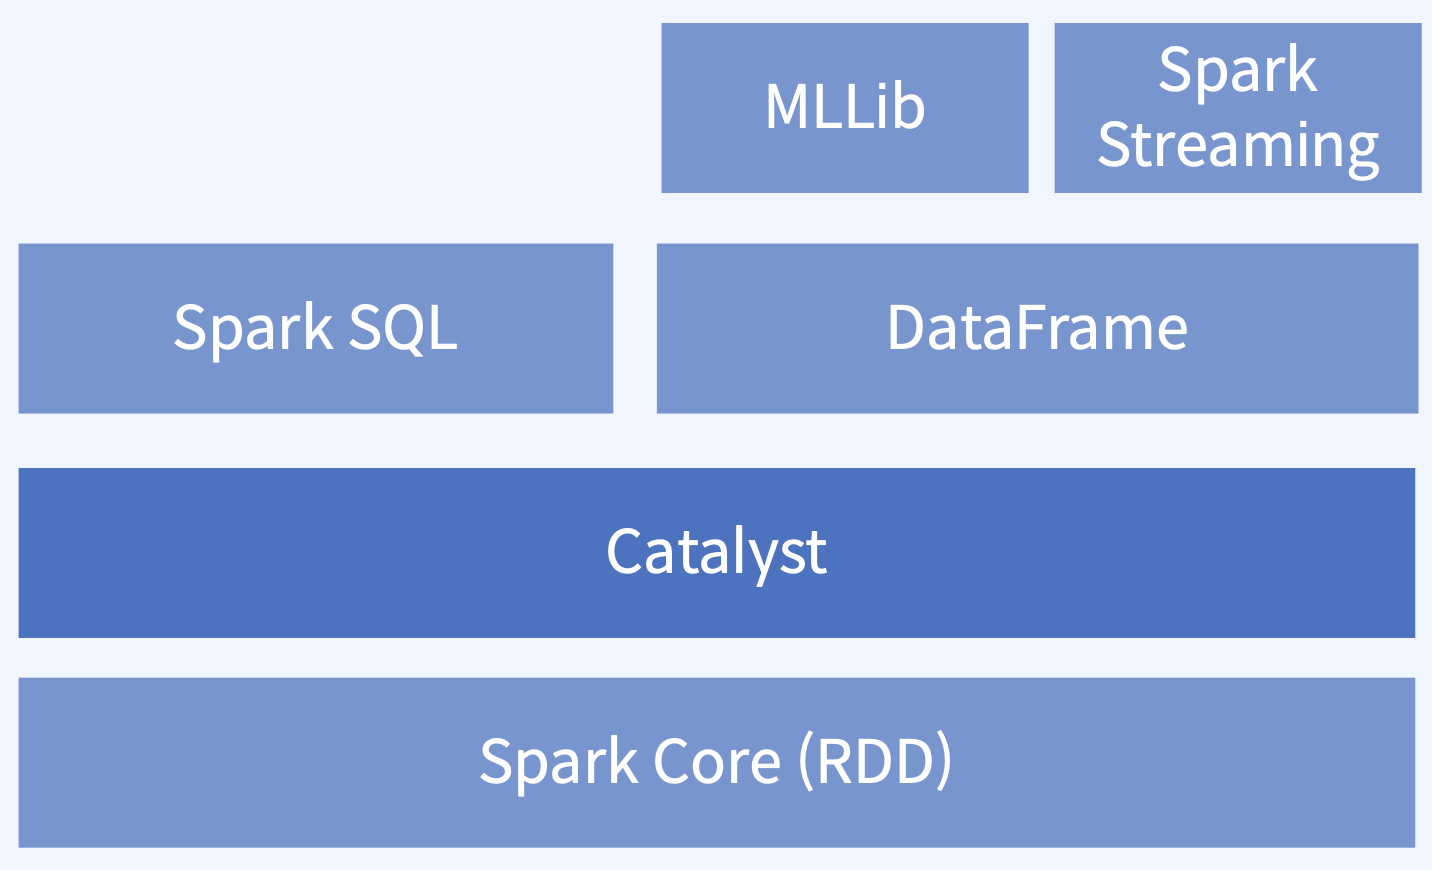

카탈리스트는 스파크 코어(Core) RDD 위에 있고 카탈리스트 위에 SQL과 데이터 프레임이 있다.

SQL과 데이터 프레임을 동시에 쓸 수 있는 것이 카탈리스트가 있기 때문이다.

데이터 프레임 위에 MLlib과 스파크 스트리밍(Streaming)같은 컴파운드(compound)들이 있다.

**카탈리스트의 목적**   로지컬 플랜(Logical Plan)을 피지컬 플랜(Physical Plan)으로 바꾸는 일을 한다.

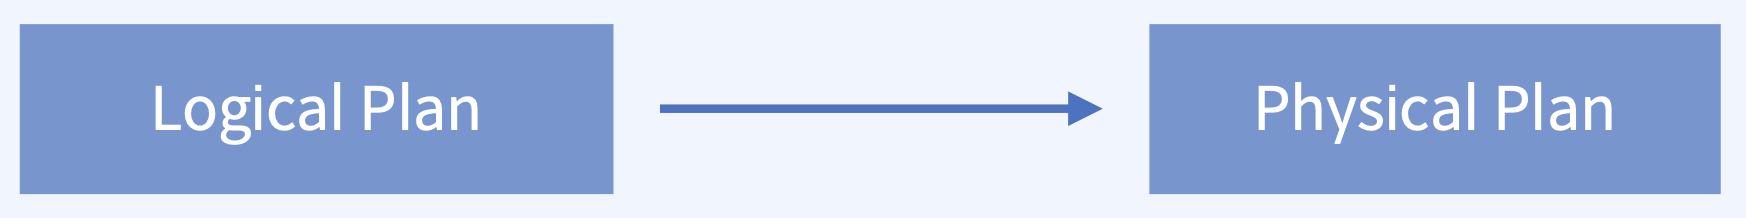

**로지컬 플랜(Logical Plan)**

수행해야하는 모든 트랜스포메이션(transformation) 단계에 대한 추상화를 진행한다.

데이터가 어떻게 변해야 하는지 정의하지만, 실제 어디서 어떻게 동작하는 지는 정의하지 않는다.

사용자가 지정한 대로 변하는 과정을 정의한 것이다.

스파크가 컬럼이나 테이블명을 검사하지 않고 로지컬을 만드는 것이 첫 단계이다.

**피지컬 플랜(Physical Plan)**

로지컬 플랜이 어떻게 클러스트 위에서 실행될 지 정의하는 디테일한 단계이다.

실행 전략을 만들고 코스트 모델(Cost Model)에 따라 최적화한다.

**카탈리스트의 단계**

**1. 분석**

데이터 프레임 객체의 관계(relation)를 계산한다.

컬럼의 타입과 이름 확인한다.

사용자가 잘못된 잘못된 이름을 사용했으면 이 부분에서 에러가 발생한다.

**2. 로지컬 플랜 최적화**

상수로 표현된 식을 컴파일 타임(Compile Time)에 계산한다.

상수가 있으면 따로 런타임(Runtime)을 계산할 필요가 없다.

Predicate Pushdown: join & filter => filter & join

테이블이 조인되고 필터링되면 연산이 비효율적이다.(셔플링이 일어난다.)

가능하면 필터링을 먼저 거친 후 조인을 시킨다.

Projection Pruning: 연산에 필요한 컬럼만 가져온다.

**3. 피지컬 플랜 생성**

스파크에서 실행 가능한 플랜으로 변환한다.

**4. 코드 제너레이션**

최적화된 피지컬 플랜을 실제로 컴퓨터에서 CPU로 돌릴 수 있는 자바 바이트코드(Java Bytecode)로 변환한다.

**카탈리스트 파이프라인(Pipeline)**

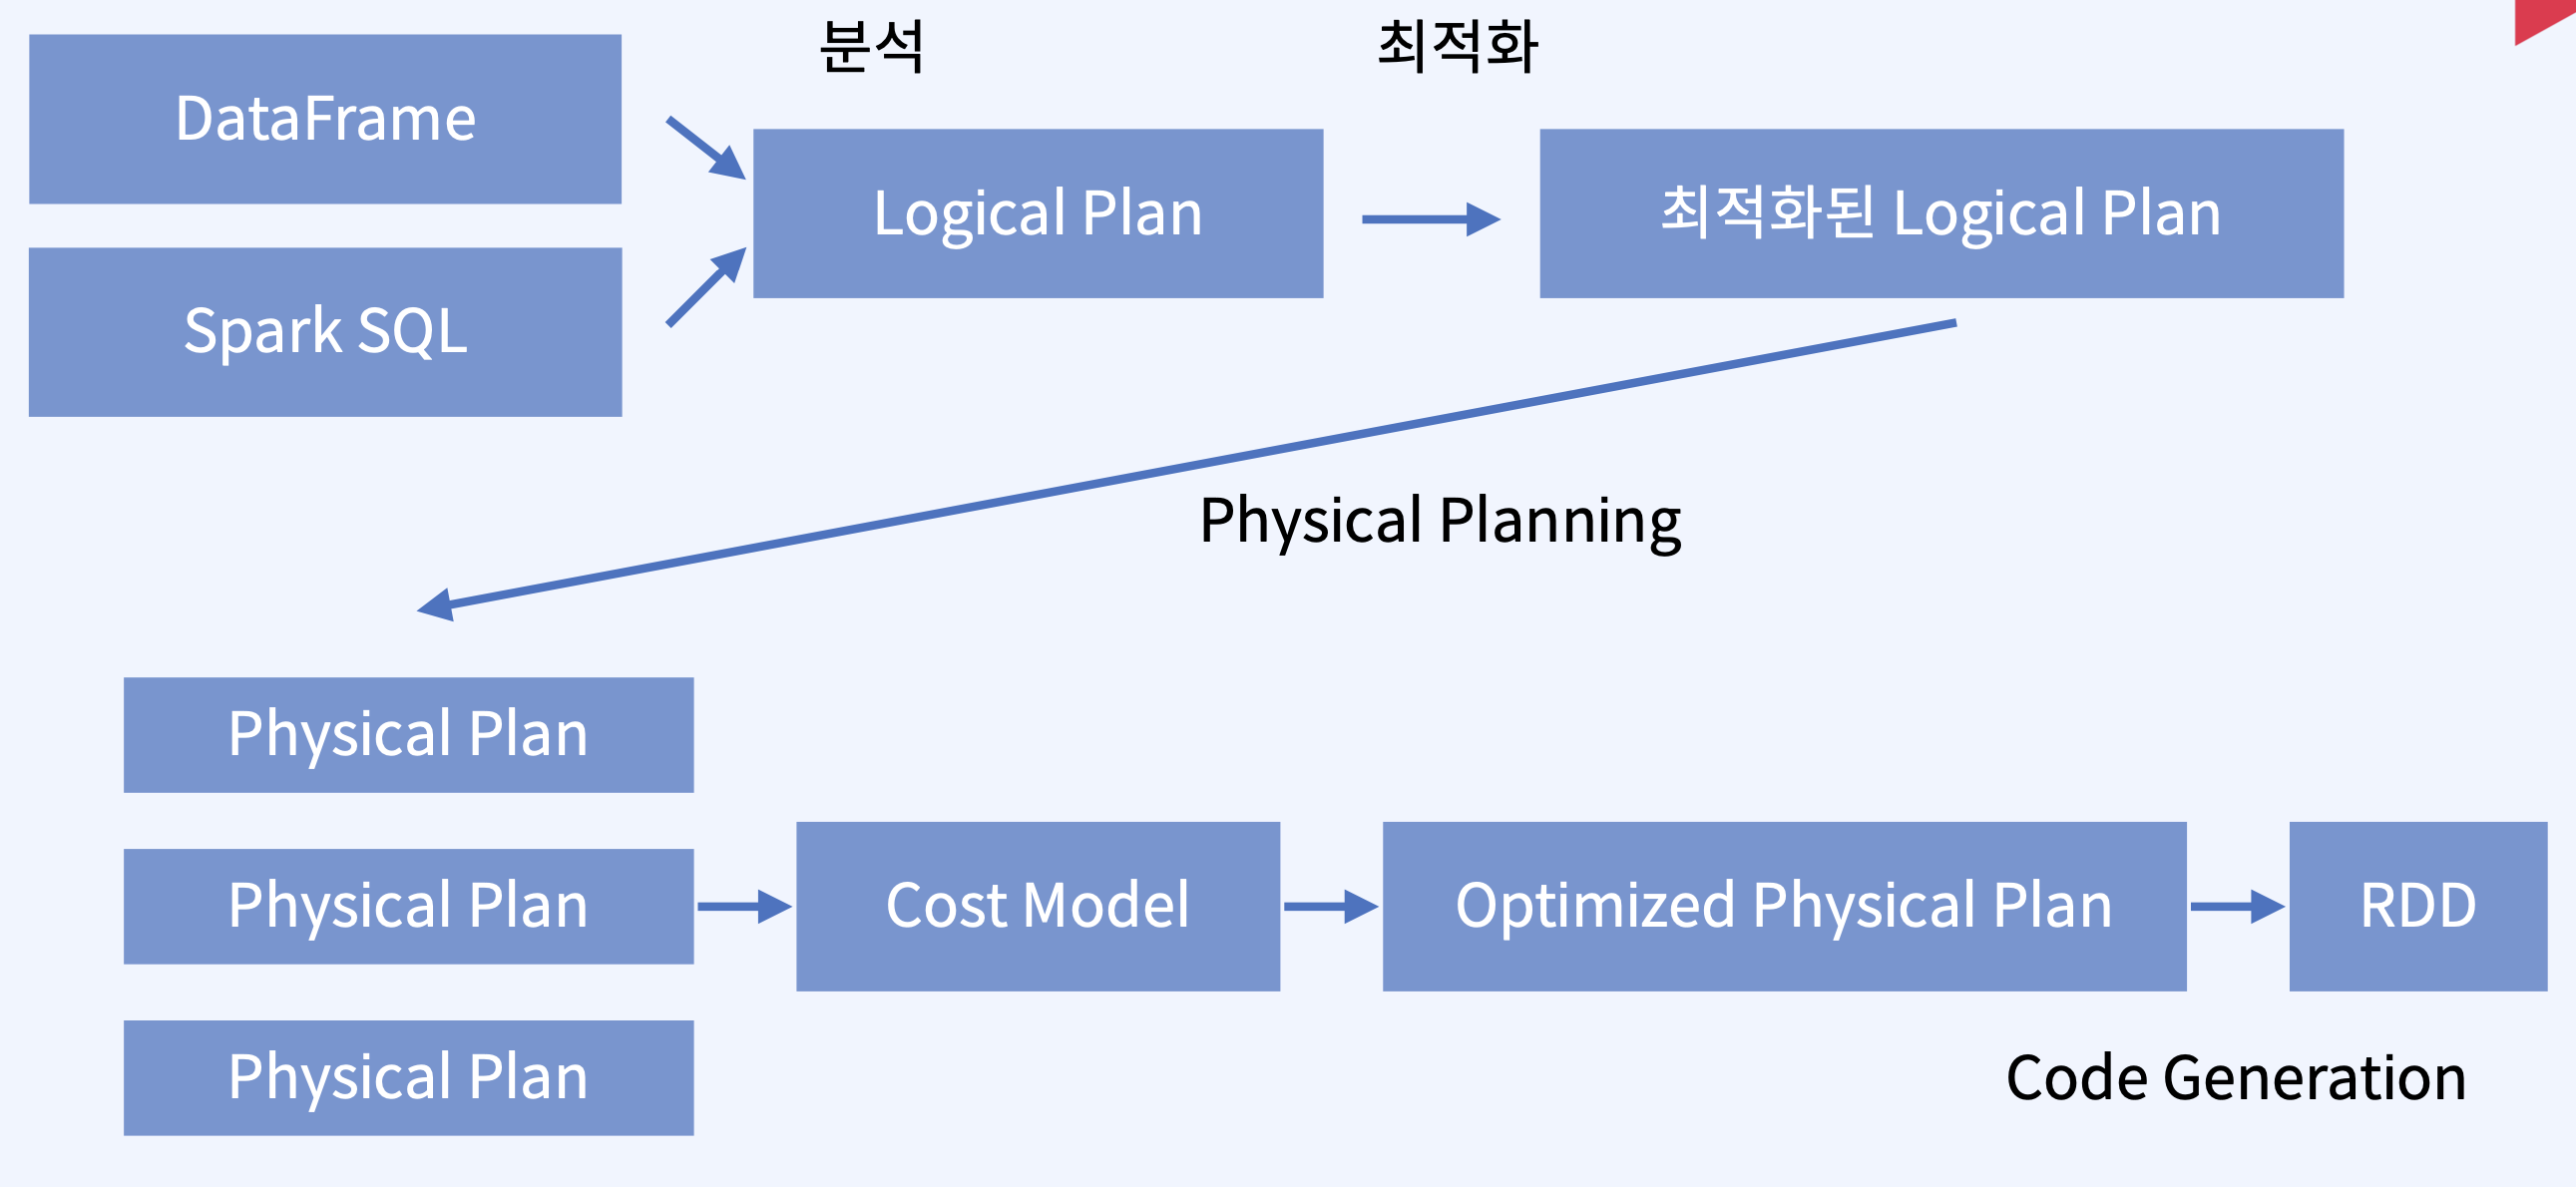

플로우를 설명하면 데이터 프레임이나 SQL의 사용자가 정의한 코드가 로지컬 플랜에 의해 분석된다.

분석된 로지컬 플랜이 최적화된 로지컬 플랜이 되고 로지컬 플랜이 여러가지의 피지컬 플랜을 만든다.

피지컬 플랜은 클러스터가 여러가지가 있으면 각 클러스터에서 무슨 일을 할 지 결정하는 디테일한 플랜이다.

그 중 코스트 모델로 어떤 것이 가장 효율적인지 뽑게 되고 그 것이 옵티마이즈드 피지컬 플랜(Optimized Physical Plan)이 된다.
다음 코드 제너레이션으로 코드가 실행된다.

**로지컬 플랜 최적화**



```
SELECT zone_data.Zone, count(*) AS trips\
FROM trip_data JOIN zone_data \
ON trip_data.PULocationID = zone_data.LocationID \
WHERE trip_data.hvfhs_license_num = 'HV0003' \
GROUP BY zone_data.Zone order by trips desc
```



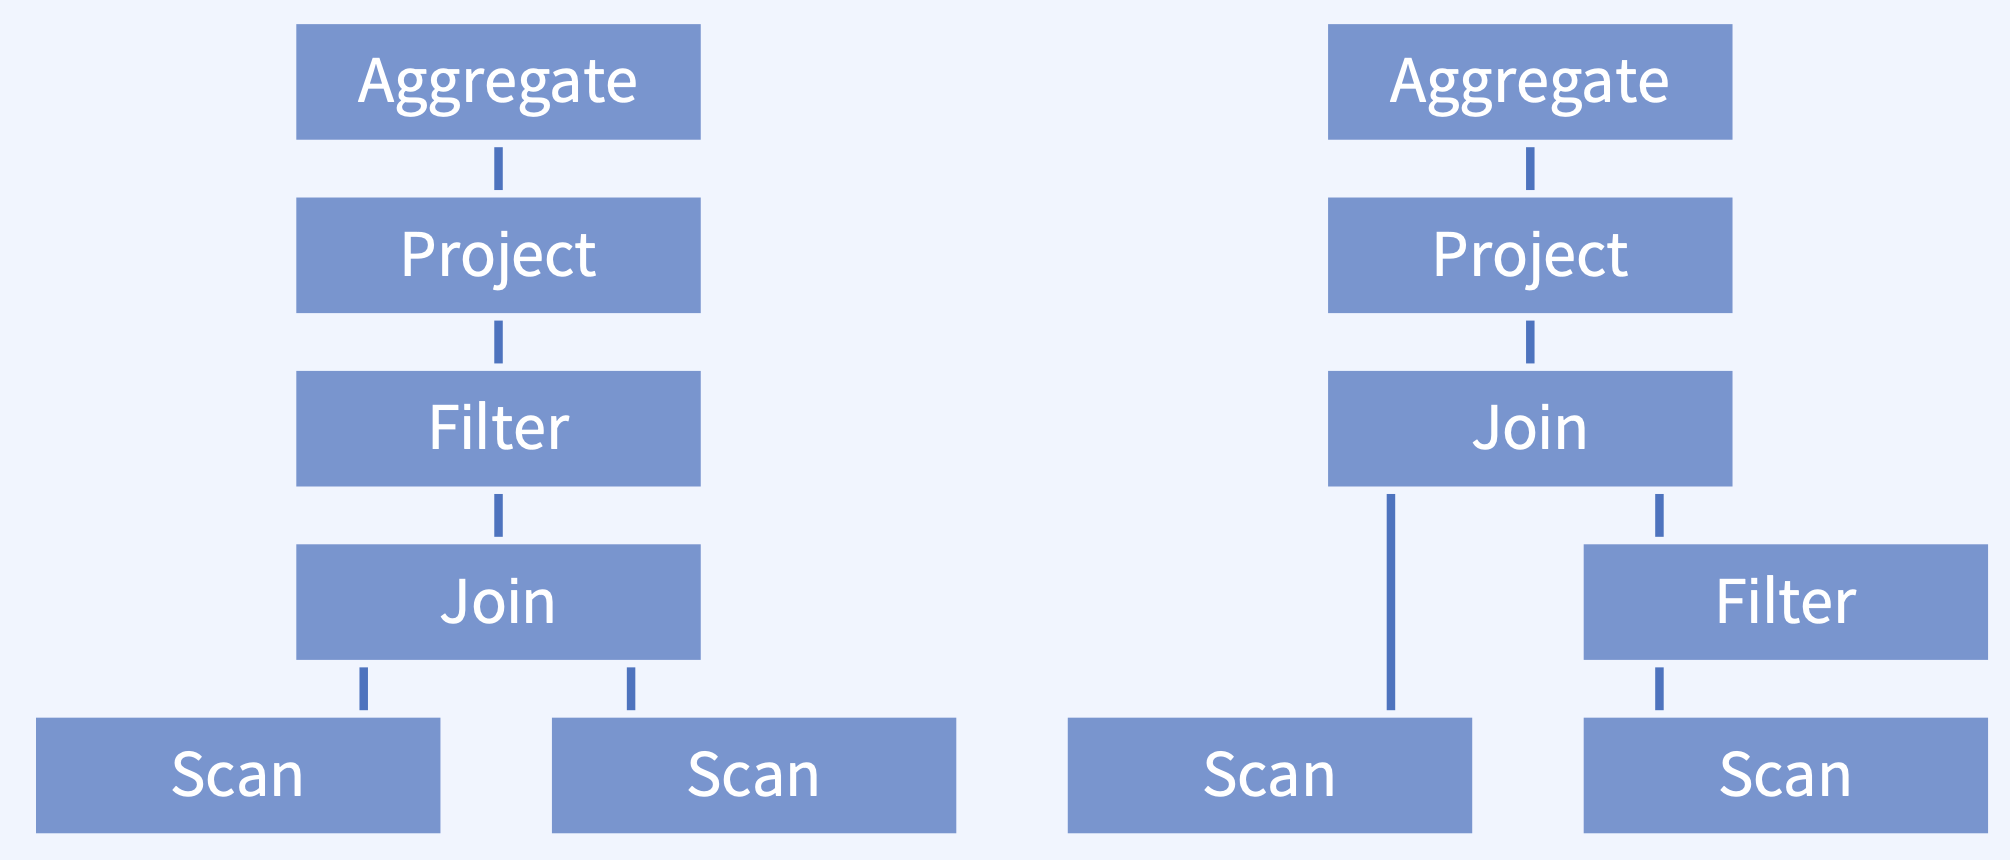

Join과 Filter의 위치를 바꾸었기 때문에 셔플이 덜 일어나게 된다.

Explain

쿼리의 로지컬 플랜과 피지컬 플랜의 단계를 알 수 있게 된다.

spark.sql(query).explain(True)

Parsed Logical Plan

Analyzed Logical Plan

Optimized Logical Plan

Physical Plan

**== Parsed Logical Plan ==**

```
'Sort ['trips DESC NULLS LAST], true

+- 'Aggregate ['zone_data.Zone], ['zone_data.Zone, 'count(1) AS trips#236]

   +- 'Filter ('trip_data.hvfhs_license_num = HV0003)

      +- 'Join Inner, ('trip_data.PULocationID = 'zone_data.LocationID)

         :- 'UnresolvedRelation [trip_data], [], false

         +- 'UnresolvedRelation [zone_data], [], false
```

**== Analyzed Logical Plan ==**


```
Zone: string, trips: bigint

Sort [trips#236L DESC NULLS LAST], true

+- Aggregate [Zone#48], [Zone#48, count(1) AS trips#236L]

   +- Filter (hvfhs_license_num#16 = HV0003)

      +- Join Inner, (PULocationID#20 = LocationID#46)

         :- SubqueryAlias trip_data

         :  +- View (`trip_data`, [hvfhs_license_num#16,dispatching_base_num#17,pickup_datetime#18,dropoff_datetime#19,PULocationID#20,DOLocationID#21,SR_Flag#22])

         :     +- Relation [hvfhs_license_num#16,dispatching_base_num#17,pickup_datetime#18,dropoff_datetime#19,PULocationID#20,DOLocationID#21,SR_Flag#22] csv

         +- SubqueryAlias zone_data

            +- View (`zone_data`, [LocationID#46,Borough#47,Zone#48,service_zone#49])

               +- Relation [LocationID#46,Borough#47,Zone#48,service_zone#49] csv
```

**== Optimized Logical Plan ==**


```
Sort [trips#236L DESC NULLS LAST], true

+- Aggregate [Zone#48], [Zone#48, count(1) AS trips#236L]

   +- Project [Zone#48]

                     :     +- FileScan csv [hvfhs_license_num#16,PULocationID#20] Batched: false, DataFilters: [isnotnull(hvfhs_license_num#16), (hvfhs_license_num#16 = HV0003), isnotnull(PULocationID#20)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/keon/fastcampus/data-engineering/01-spark/data/fhvhv_tripd..., PartitionFilters: [], PushedFilters: [IsNotNull(hvfhs_license_num), EqualTo(hvfhs_license_num,HV0003), IsNotNull(PULocationID)], ReadSchema: struct<hvfhs_license_num:string,PULocationID:int>

                     +- BroadcastExchange HashedRelationBroadcastMode(List(cast(input[0, int, false] as bigint)),false), [id=#637]

                        +- Filter isnotnull(LocationID#46)

                           +- FileScan csv [LocationID#46,Zone#48] Batched: false, DataFilters: [isnotnull(LocationID#46)], Format: CSV, Location: InMemoryFileIndex(1 paths)[file:/Users/keon/fastcampus/data-engineering/01-spark/data/taxi+_zone_..., PartitionFilters: [], PushedFilters: [IsNotNull(LocationID)], ReadSchema: struct<LocationID:int,Zone:string>
```



**텅스텐(Tungsten)**

피지컬 플랜이 선택되고 나면 분산 환경에서 실행될 바이트 코드가 만들어지게 된다.

이 프로세스를 코드 제너레이션(Code Generation)이라고 부른다.

스파크 엔진의 성능 향상이 목적이다.

메모리 관리를 최적화하고 캐시를 활용하여 연산하며, 코드를 생성한다.